Epoch 1/4 - Train:  54%|█████▍    | 326/601 [01:24<01:11,  3.85it/s]c:\Users\Aman\AppData\Local\Programs\Python\Python311\Lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 1/4 - Val  : 100%|██████████| 99/99 [00:23<00:00,  4.18it/s]


Epoch 1/4 | Train Acc: 73.96% | Val Acc: 82.39%


Epoch 2/4 - Val  : 100%|██████████| 99/99 [00:24<00:00,  4.03it/s]


Epoch 2/4 | Train Acc: 89.51% | Val Acc: 90.53%


Epoch 3/4 - Val  : 100%|██████████| 99/99 [00:23<00:00,  4.15it/s]


Epoch 3/4 | Train Acc: 92.28% | Val Acc: 91.10%


Epoch 4/4 - Val  : 100%|██████████| 99/99 [00:23<00:00,  4.16it/s]

Epoch 4/4 | Train Acc: 93.40% | Val Acc: 92.50%


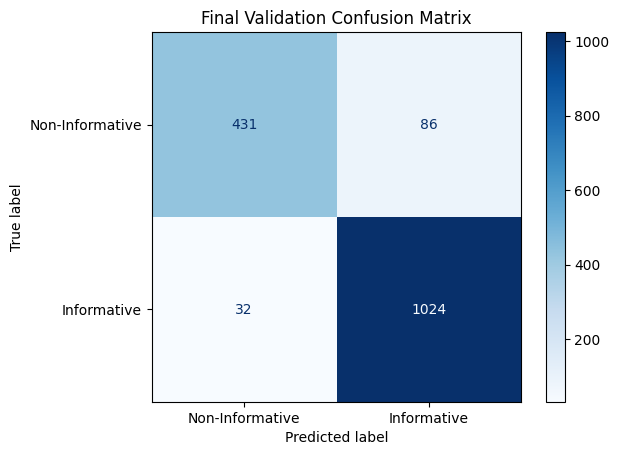

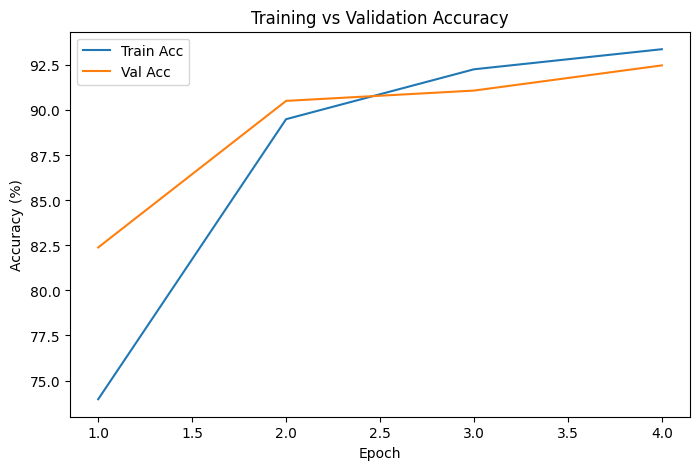

Training & validation complete.


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from transformers import CLIPProcessor, CLIPModel
from tqdm import tqdm
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import torch.nn.functional as F

# -------------------- Dataset --------------------
class MultimodalDataset(Dataset):
    def __init__(self, dataframe, image_dir, processor, max_length=77):
        self.data = dataframe
        self.image_dir = image_dir
        self.processor = processor
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text = self.data.iloc[idx]['tweet_text']
        image_path = self.image_dir + self.data.iloc[idx]['image']
        label = 1 if self.data.iloc[idx]['label'] == 'informative' else 0

        image = Image.open(image_path).convert("RGB")
        text_inputs = self.processor.tokenizer(
            text,
            padding='max_length',
            truncation=True,
            max_length=self.max_length,
            return_tensors='pt'
        )
        image_inputs = self.processor(images=image, return_tensors="pt")["pixel_values"]

        return {
            'input_ids': text_inputs.input_ids.squeeze(0),
            'attention_mask': text_inputs.attention_mask.squeeze(0),
            'pixel_values': image_inputs.squeeze(0)
        }, torch.tensor(label, dtype=torch.long)

# -------------------- CoCoOp-Style Contrastive Classifier --------------------
class CoCoOpContrastive(nn.Module):
    def __init__(self, clip_model, processor, prompt_length=4, meta_hidden=512, temperature=1.0):
        super().__init__()
        self.clip = clip_model
        self.processor = processor
        for param in self.clip.parameters():
            param.requires_grad = False

        D = self.clip.config.projection_dim
        self.prompt_length = prompt_length
        self.token_emb = self.clip.text_model.embeddings.token_embedding
        self.pos_emb = self.clip.text_model.embeddings.position_embedding
        self.ln_final = self.clip.text_model.final_layer_norm
        self.text_proj = self.clip.text_projection

        # learnable base prompts
        self.prompt_tokens = nn.Parameter(torch.randn(prompt_length, D))
        # meta-net for adaptive delta
        self.meta_net = nn.Sequential(
            nn.Linear(D*2, meta_hidden),
            nn.ReLU(),
            nn.Linear(meta_hidden, prompt_length * D)
        )
        self.temperature = nn.Parameter(torch.tensor(temperature))
        self.class_names = ["Non-Informative", "Informative"]

        # tokenize class names once using processor.tokenizer
        enc = self.processor.tokenizer(
            [f"a photo of a {c}" for c in self.class_names],
            padding='longest',
            truncation=True,
            return_tensors='pt'
        )
        self.register_buffer('class_input_ids', enc.input_ids)
        self.register_buffer('class_attention_mask', enc.attention_mask)

    def forward(self, inputs):
        # extract base features
        image_feat = self.clip.get_image_features(inputs['pixel_values'])  # [B, D]
        text_feat = self.clip.get_text_features(
            inputs['input_ids'], inputs['attention_mask']
        )  # [B, D]

        # compute adaptive prompt tokens
        meta_in = torch.cat([image_feat, text_feat], dim=-1)
        delta = self.meta_net(meta_in).view(
            -1, self.prompt_length, image_feat.size(-1)
        )
        prompts = self.prompt_tokens.unsqueeze(0) + delta  # [B, prompt_length, D]

        B = prompts.size(0)
        C = len(self.class_names)
        # expand prompts and class token sequences
        prompts_exp = prompts.unsqueeze(1).expand(B, C, -1, -1).reshape(
            B*C, self.prompt_length, -1
        )
        cls_ids = self.class_input_ids.unsqueeze(0).expand(B, -1, -1).reshape(B*C, -1)
        cls_emb = self.token_emb(cls_ids)

        # combine prompts + class tokens
        full_emb = torch.cat([prompts_exp, cls_emb], dim=1)  # [B*C, L', D]
        Lp = full_emb.size(1)
        pos_ids = torch.arange(Lp, device=full_emb.device).unsqueeze(0)
        full = full_emb + self.pos_emb(pos_ids)

        # encode through text transformer
        out = self.clip.text_model.encoder(full)[0]
        cls_out = out[:, 0]
        ln = self.ln_final(cls_out)
        text_emb = self.text_proj(ln).view(B, C, -1)  # [B, C, D]

        # contrastive logits
        logits = F.cosine_similarity(
            image_feat.unsqueeze(1), text_emb, dim=-1
        ) * self.temperature
        return logits  # [B, C]

# -------------------- Training & Validation --------------------
if __name__ == '__main__':
    # Setup
    processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
    clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")

    train_df = pd.read_csv('crisismmd_datasplit_all/crisismmd_datasplit_all/task_informative_text_img_train.tsv', sep='\t')
    val_df   = pd.read_csv('crisismmd_datasplit_all/crisismmd_datasplit_all/task_informative_text_img_dev.tsv', sep='\t')
    train_df = train_df[train_df['label_text_image'] == 'Positive']
    val_df   = val_df[val_df['label_text_image'] == 'Positive']
    image_dir = ''

    train_ds = MultimodalDataset(train_df, image_dir, processor)
    val_ds   = MultimodalDataset(val_df, image_dir, processor)
    train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
    val_loader   = DataLoader(val_ds, batch_size=16)

    model = CoCoOpContrastive(clip_model, processor)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    optimizer = optim.AdamW(model.parameters(), lr=1e-5)
    loss_fn   = nn.CrossEntropyLoss()

    train_acc_history = []
    val_acc_history   = []

    epochs = 4
    for epoch in range(epochs):
        # --- Training Phase ---
        model.train()
        train_correct = 0
        train_total   = 0
        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} - Train"):
            inputs = {k: v.to(device) for k, v in inputs.items()}
            labels = labels.to(device)

            optimizer.zero_grad()
            logits = model(inputs)                # [B, C]
            loss   = loss_fn(logits, labels)
            loss.backward()
            optimizer.step()

            preds = logits.argmax(dim=1)
            train_correct += (preds == labels).sum().item()
            train_total   += labels.size(0)

        train_acc = train_correct / train_total * 100
        train_acc_history.append(train_acc)

        # --- Validation Phase ---
        model.eval()
        val_correct = 0
        val_total   = 0
        all_labels  = []
        all_preds   = []
        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} - Val  "):
                inputs = {k: v.to(device) for k, v in inputs.items()}
                labels = labels.to(device)

                logits = model(inputs)            # [B, C]
                preds  = logits.argmax(dim=1)

                val_correct += (preds == labels).sum().item()
                val_total   += labels.size(0)
                all_labels.extend(labels.cpu().tolist())
                all_preds.extend(preds.cpu().tolist())

        val_acc = val_correct / val_total * 100
        val_acc_history.append(val_acc)

        print(f"Epoch {epoch+1}/{epochs} | Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")

    # --- Final Confusion Matrix ---
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(cm, display_labels=model.class_names)
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Final Validation Confusion Matrix")
    plt.show()

    # --- Accuracy Curves ---
    plt.figure(figsize=(8,5))
    plt.plot(range(1, len(train_acc_history)+1), train_acc_history, label='Train Acc')
    plt.plot(range(1, len(val_acc_history)+1), val_acc_history, label='Val Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Training vs Validation Accuracy')
    plt.legend()
    plt.show()

    print("Training & validation complete.")


c:\Users\Aman\AppData\Local\Programs\Python\Python311\Lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Test Accuracy : 93.29%
Test Precision: 93.04%
Test Recall   : 97.28%
Test F1 Score : 95.11%


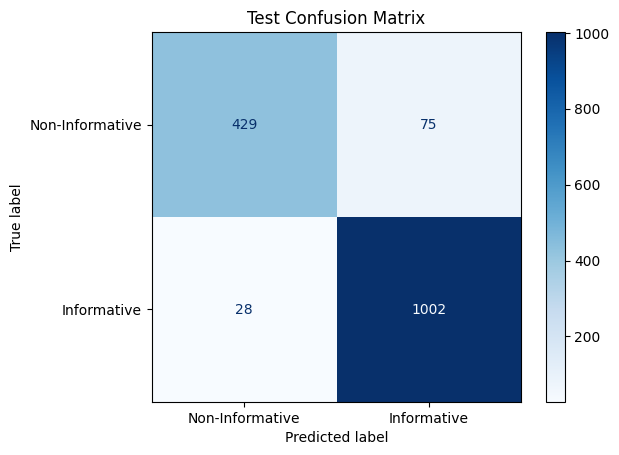

In [4]:
import torch
from torch.utils.data import DataLoader
import pandas as pd
from transformers import CLIPProcessor, CLIPModel
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay



# -------------------- Testing & Metrics Only --------------------
# Load and filter the test dataset
test_df = pd.read_csv(
    'crisismmd_datasplit_all/crisismmd_datasplit_all/task_informative_text_img_test.tsv', sep='\t'
)
test_df_positive = test_df[test_df['label_text_image'] == 'Positive']

# Prepare test DataLoader
test_dataset = MultimodalDataset(test_df_positive, image_dir, processor)
test_loader  = DataLoader(test_dataset, batch_size=16)

# Evaluate using the in-memory trained model
model.eval()
all_labels, all_preds = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = {k: v.to(device) for k, v in inputs.items()}
        logits = model(inputs)           # [B, 2]
        preds  = logits.argmax(dim=1).cpu().tolist()
        all_preds.extend(preds)
        all_labels.extend(labels.tolist())

# Compute metrics
acc  = accuracy_score(all_labels, all_preds) * 100
prec = precision_score(all_labels, all_preds, zero_division=0) * 100
rec  = recall_score(all_labels, all_preds, zero_division=0) * 100
f1   = f1_score(all_labels, all_preds, zero_division=0) * 100

print(f"Test Accuracy : {acc:.2f}%")
print(f"Test Precision: {prec:.2f}%")
print(f"Test Recall   : {rec:.2f}%")
print(f"Test F1 Score : {f1:.2f}%")

# Plot confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(cm, display_labels=model.class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Test Confusion Matrix")
plt.show()
